# Above 8 000: Data at Altitude

## Basic setup

### Import necessary libraries  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Ignore casting warnings

In [2]:
pd.set_option('future.no_silent_downcasting', True)

### Load information from the datasets

In [3]:
deaths  = pd.read_csv('data\\deaths.csv',          low_memory=False)          # ~1,1 k rows
exped   = pd.read_csv('data\\expeditions.csv',     low_memory=False)          # ~480 rows
peaks   = pd.read_csv('data\\peaks.csv',           low_memory=False)          # ~11 k rows
summit  = pd.read_csv('data\\summiters.csv',       low_memory=False)          # ~16 k rows

## Show basic information about tables

### deaths-Table

In [4]:
deaths.columns

Index(['peak_id', 'peak_name', 'name', 'yr_season', 'date', 'time',
       'citizenship', 'gender', 'age', 'is_o2_used', 'is_summiter',
       'cause_of_death'],
      dtype='object')

In [5]:
deaths.index

RangeIndex(start=0, stop=1104, step=1)

In [6]:
deaths.head(10)

,peak_id,peak_name,name,yr_season,date,time,citizenship,gender,age,is_o2_used,is_summiter,cause_of_death
0,AMAD,Ama Dablam,Michael John (Mike) Harris,1959 Spr,May 21,08:30,UK,M,33,No,.,Fall (6550m)
1,AMAD,Ama Dablam,George James Fraser,1959 Spr,May 21,08:30,UK,M,27,No,.,Fall (6550m)
2,AMAD,Ama Dablam,Kenneth James (Ken) Hyslop,1979 Aut,Oct 24,11:15,New Zealand,M,23,No,.,Avalanche (6100m)
3,AMAD,Ama Dablam,Guido Bumann,1983 Aut,Oct 27,20:00,Switzerland,M,31,No,.,Fall (5300m)
4,AMAD,Ama Dablam,Maya Senn,1983 Aut,Oct 27,20:00,Switzerland,F,28,No,.,Fall (5300m)
5,AMAD,Ama Dablam,Makoto Ishibashi,1985 Spr,May 04,09:30,Japan,M,32,No,Y,Fall (5900m)
6,AMAD,Ama Dablam,Charlie Eckenfelder,1988 Spr,Apr 09,16:00,Canada,M,33,No,.,Fall (6200m)
7,AMAD,Ama Dablam,Jose Joaquin Goni Azanza,1992 Spr,Apr 19,19:00,Spain,M,36,No,Y,Fall (6750m)
8,AMAD,Ama Dablam,Karine Van Dooren,1992 Aut,Oct 26,NaN,Belgium,F,35,No,.,Fall (6000m)
9,AMAD,Ama Dablam,Jean Corniglion,1998 Aut,Oct 31,18:00,France,M,60,No,.,AMS (4600m)


### expedition-Table

In [7]:
exped.columns

Index(['peak_id', 'peak_name', 'nationality', 'year', 'season', 'host_cntr',
       'other_cntrs', 'sponsor', 'leaders', 'rte_1_name', 'rte_2_name',
       'rte_3_name', 'rte_4_name', 'team_asc_1', 'team_asc_2', 'team_asc_3',
       'team_asc_4', 'is_disputed', 'is_claim', 'is_commercial_rte',
       'is_standard_rte', 'other_smts', 'approach', 'bc_arrived', 'bc_left',
       'total_days', 'exp_result', 'is_traverse', 'is_ski_snowboard',
       'is_parapente', 'term_note', 'summit_day', 'time', 'max_elev_reached',
       'summit_days', 'total_mbrs', 'mbrs_summited', 'mbrs_deaths',
       'high_camps', 'hired_abc', 'hired_summits', 'hired_deaths',
       'rope_fixed', 'is_no_hired_abc', 'is_o2_not_used', 'is_o2_climbing',
       'is_o2_descent', 'is_o2_sleeping', 'is_o2_medical', 'is_o2_used',
       'is_o2_unkwn', 'had_o2', 'camp_sites', 'accidents', 'achievements',
       'agency', 'members'],
      dtype='object')

In [8]:
exped.index

RangeIndex(start=0, stop=10494, step=1)

In [9]:
exped.head(10)

,peak_id,peak_name,nationality,year,season,host_cntr,other_cntrs,sponsor,leaders,rte_1_name,...,is_o2_sleeping,is_o2_medical,is_o2_used,is_o2_unkwn,had_o2,camp_sites,accidents,achievements,agency,members
0,ACHN,Aichyn,Japan,2015,Autumn,Nepal,NaN,Doshisha University Alpine Club Western Nepal ...,Hiroki Senda,NW side,...,0,0,0,0,0,"Smt(03,08/09)",NaN,NaN,Cosmo Treks,"01 Hiroki (Yuki) Senda (L)(S), Japan 02 Ms. ..."
1,ACHN,Aichyn,France,2015,Autumn,Nepal,NaN,Paulo Aichyn Expedition 2015,Paulo Grobel,N Ridge-W Ridge,...,0,0,0,0,0,Smt(25/09),NaN,NaN,Yeti Adventure,"01 Paul Marc (Paulo) Grobel (L)(S), France 02..."
2,ACHN,Aichyn,France,2018,Autumn,Nepal,NaN,French Aichyn Expeditions 2018,"Francois Damilano, Gregoire Lestienne",NaN,...,0,0,0,0,0,NaN,NaN,NaN,Himalayan Travellers Nepal,"01 Francois Damilano (L), France 02 Gregoire..."
3,AMAD,Ama Dablam,UK,1958,Autumn,Nepal,Italy,NaN,Alfred Gregory,SW Ridge,...,0,0,0,0,0,"BC,C1,C2,xxx(6000m)",NaN,NaN,NaN,"01 Alfred John (Alf) Gregory (L), UK 02 Rich..."
4,AMAD,Ama Dablam,UK,1959,Spring,Nepal,NaN,NaN,J. H. Emlyn Jones,N Ridge-NE Spur,...,0,0,0,0,1,"BC(17/04,5030m),C1(01/05,5440m),C2(05/05,5850m...",Fraser and Harris disappeared on way to summit...,NaN,NaN,"01 John Hubert Emlyn Jones (L), UK 02 George..."
5,AMAD,Ama Dablam,New Zealand,1961,Spring,Nepal,"UK, USA",Himalayan Scientific and Mountaineering Expedi...,Edmund Hillary,SW Ridge,...,0,0,0,0,0,"BC(4575m),C1(5800m),C2,C3,C4,Smt(13/03)",NaN,1st ascent,NaN,"01 Edmund Percival Hillary (L), New Zealand 0..."
6,AMAD,Ama Dablam,France,1978,Autumn,Nepal,NaN,First French Expedition to Ama Dablam,Jean Clemenson,SW Ridge,...,0,0,0,0,1,"BC(01/10,4950m),C1(11/10,5650m),xxx(20-21/10,6...",NaN,NaN,NaN,"01 Jean Robert Clemenson (L), France 02 Bern..."
7,AMAD,Ama Dablam,USA,1979,Spring,Nepal,W Germany,American Ama Dablam Expedition,Roger C. Brown,SW Ridge,...,0,0,0,0,1,"BC(29/03,4600m),ABC(03/04,5000m),C1(05/04,5750...",No accidents. Boysen walked to BC Ok in larger...,1st solo ascent,NaN,"01 Roger C. Brown (L), USA 02 Thomas McCalla..."
8,AMAD,Ama Dablam,France,1979,Autumn,Nepal,NaN,Expedition of the Guides of Briancon to the Hi...,Raymond Renaud,N Ridge,...,0,0,0,0,1,"BC(25/09,5100m),C1(01/10,5850m),C2(08/10,6000m...",NaN,NaN,NaN,"01 Jean Francois Manificat (L)(S), France 02 ..."
9,AMAD,Ama Dablam,New Zealand,1979,Autumn,Nepal,NaN,New Zealand Ama Dablam Expedition 1979,Peter Hillary,W Face,...,0,0,0,0,0,"BC(15/10,4575m),C1(17/10,5500m),xxx(24/10,6100m)",Peter Hillary seriously injured of the three w...,NaN,NaN,"01 Peter Edmund Hillary (L), New Zealand 02 ..."


### peaks-Table

In [10]:
peaks.columns

Index(['peak_id', 'peak_name', 'host_contries', 'alternative_names',
       'height_m', 'height_ft', 'location', 'region', 'restrictions',
       'climb_status', 'is_open', 'is_unlisted', 'is_trekking', 'trek_year',
       'first_asc_yr', 'first_asc_season', 'first_asc_date', 'countries',
       'first_summiters', 'summiters_notes'],
      dtype='object')

In [11]:
peaks.index

RangeIndex(start=0, stop=461, step=1)

In [12]:
peaks.head(10)

,peak_id,peak_name,host_contries,alternative_names,height_m,height_ft,location,region,restrictions,climb_status,is_open,is_unlisted,is_trekking,trek_year,first_asc_yr,first_asc_season,first_asc_date,countries,first_summiters,summiters_notes
0,ACHN,Aichyn,Nepal only,"Aychin, Ashvin",6055,19865,Nalakankar/Chandi/Changla,Far West-Kanjiroba,Opened in 2014,Climbed,1,0,0,0,2015,Autumn,Sep 03,Japan,"Hiroki Senda, et al",NaN
1,AGLE,Agole East,Nepal only,Angole East,6675,21900,Rolwaling,Khumbu-Rolwaling-Makalu,Opened in 2014,Unclimbed,1,0,0,0,0,All,NaN,NaN,Unclimbed,NaN
2,AMAD,Ama Dablam,Nepal only,Amai Dablang,6814,22356,Khumbu,Khumbu-Rolwaling-Makalu,NaN,Climbed,1,0,0,0,1961,Spring,Mar 13,"New Zealand, USA, UK","Mike Gill, Wally Romanes, Barry Bishop, Michae...",NaN
3,AMOT,Amotsang,Nepal only,Amatson,6393,20974,Damodar,Annapurna-Damodar-Peri,Opened in 2002,Climbed,1,0,0,0,2019,Autumn,Oct 24,Germany,Jost Kobusch,Possibly climbed earlier
4,AMPG,Amphu Gyabjen,Nepal only,NaN,5630,18471,Khumbu,Khumbu-Rolwaling-Makalu,Opened in 2002,Climbed,1,0,0,0,1953,Spring,Apr 11,UK,"John Hunt, Tom Bourdillon",NaN
5,AMPH,Amphu I,Nepal only,NaN,6740,22113,Khumbu,Khumbu-Rolwaling-Makalu,Opened in 2002,Climbed,1,0,0,0,2013,Autumn,Oct 09,S Korea,"Ahn Il-Evn, An Chi-Young, Kim Young-Mi, Oh You...",NaN
6,AMPM,Amphu Middle,Nepal only,Amphu North,6202,20348,Khumbu,Khumbu-Rolwaling-Makalu,Requires permit for Amphu I,Climbed,0,1,0,0,2008,Spring,Apr 20,Germany,"Olaf Rieck, Alexander Graeber",NaN
7,ANID,Anidesh Chuli,Nepal only,White Wave Peak,6808,22336,Kangchenjunga/Simhalila,Kangchenjunga-Janak,Opened in 2002,Unclimbed,1,0,0,0,0,All,NaN,NaN,Unclimbed,NaN
8,ANN1,Annapurna I,Nepal only,NaN,8091,26545,Annapurna,Annapurna-Damodar-Peri,NaN,Climbed,1,0,0,0,1950,Spring,Jun 03,France,"Maurice Herzog, Louis Lachenal",NaN
9,ANN2,Annapurna II,Nepal only,NaN,7937,26040,Annapurna,Annapurna-Damodar-Peri,NaN,Climbed,1,0,0,0,1960,Spring,May 17,"UK, Nepal","Richard Grant, Chris Bonington, Ang Nyima Sherpa",NaN


### summit-Table

In [13]:
summit.columns

Index(['peak_id', 'peak_name', 'name', 'yr_season', 'date', 'time',
       'citizenship', 'gender', 'age', 'is_o2_used', 'died_on_descent',
       'host_country'],
      dtype='object')

In [14]:
summit.index

RangeIndex(start=0, stop=30679, step=1)

In [15]:
summit.head(10)

,peak_id,peak_name,name,yr_season,date,time,citizenship,gender,age,is_o2_used,died_on_descent,host_country
0,ACHN,Aichyn,Kaya Ko,2015 Aut,Sep 03,13:15,Japan,F,23,No,.,Nepal
1,ACHN,Aichyn,Yuma Ono,2015 Aut,Sep 03,13:15,Japan,M,19,No,.,Nepal
2,ACHN,Aichyn,Shintaro Saito,2015 Aut,Sep 03,13:15,Japan,M,25,No,.,Nepal
3,ACHN,Aichyn,Hiroki (Yuki) Senda,2015 Aut,Sep 03,13:15,Japan,M,23,No,.,Nepal
4,ACHN,Aichyn,Yuto Tamaki,2015 Aut,Sep 03,13:15,Japan,M,22,No,.,Nepal
5,ACHN,Aichyn,"Rajan Lama Bhote (Hatiya-1, Makalu-Barun)",2015 Aut,Sep 25,13:30,Nepal,M,28,No,.,Nepal
6,ACHN,Aichyn,Jean-Paul Emole Gabriel Charpentier,2015 Aut,Sep 25,13:30,France,M,60,No,.,Nepal
7,ACHN,Aichyn,Pierre Robert Roger Derieux,2015 Aut,Sep 25,13:30,France,M,50,No,.,Nepal
8,ACHN,Aichyn,Paul Marc (Paulo) Grobel,2015 Aut,Sep 25,13:30,France,M,58,No,.,Nepal
9,ACHN,Aichyn,Dhan Bahadur Magar,2015 Aut,Sep 25,13:30,Nepal,M,29,No,.,Nepal


## Sort Eight-thousanders

In [21]:
peaks['height_m'] = pd.to_numeric(peaks['height_m'], errors='coerce') # ensure numeric datatype
eightKs = peaks.query('height_m > 8000')
eightKs.index

Index([8, 12, 13, 51, 68, 92, 173, 175, 177, 237, 238, 251, 260, 262, 450,
       451],
      dtype='int64')

## Data Analysis

### Number of expeditions per year

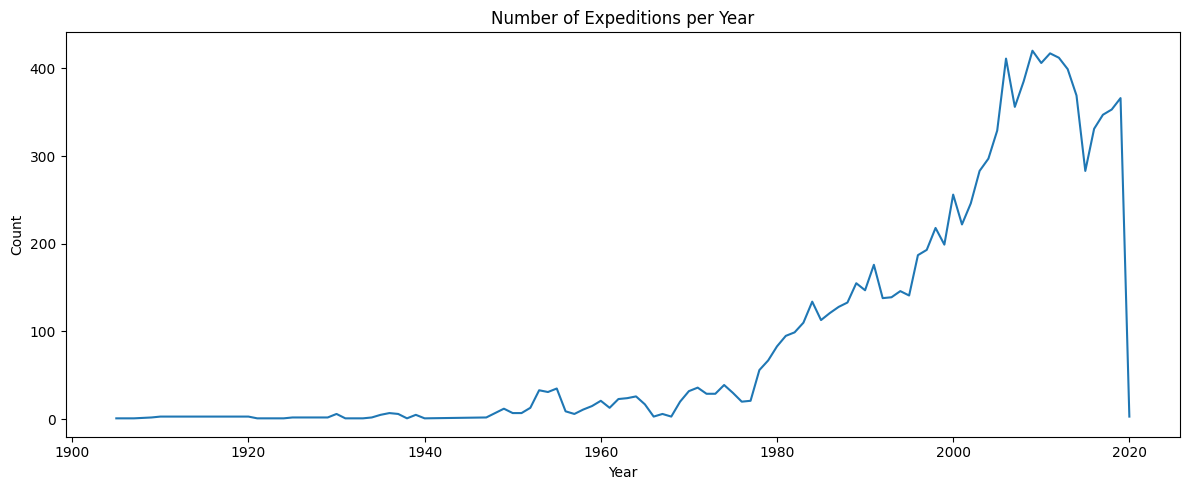

In [17]:
exped_per_year = exped.groupby('year').size().sort_index()

plt.figure(figsize=(12, 5))
exped_per_year.plot()
plt.title('Number of Expeditions per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Annual expedition success rate

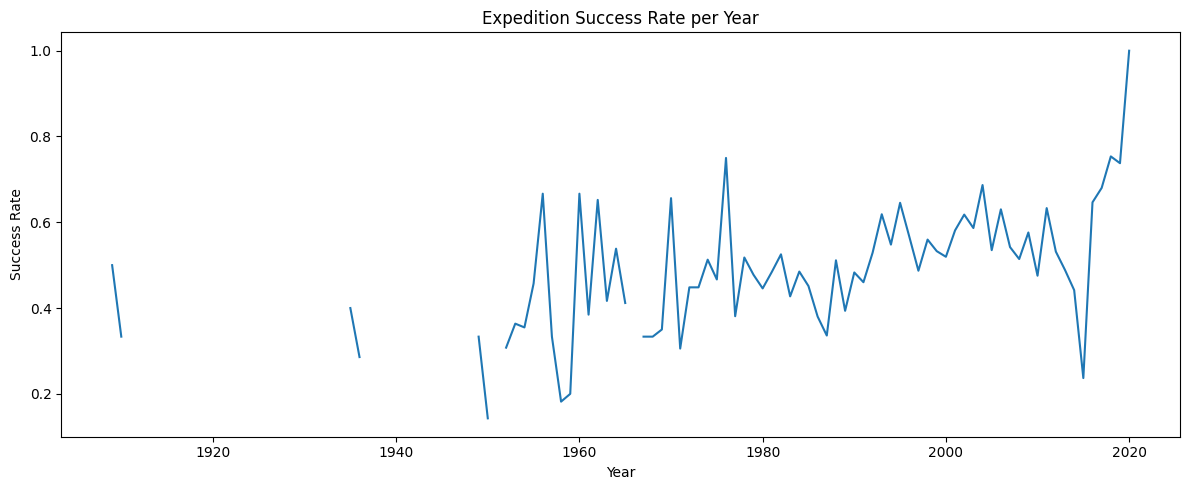

In [18]:
success = exped[exped['exp_result'] == 'Success']
success_rate = success.groupby('year').size() / exped.groupby('year').size()

plt.figure(figsize=(12, 5))
success_rate.plot()
plt.title('Expedition Success Rate per Year')
plt.xlabel('Year')
plt.ylabel('Success Rate')
plt.tight_layout()
plt.show()

### Number of expeditions with bottled oxygen use 

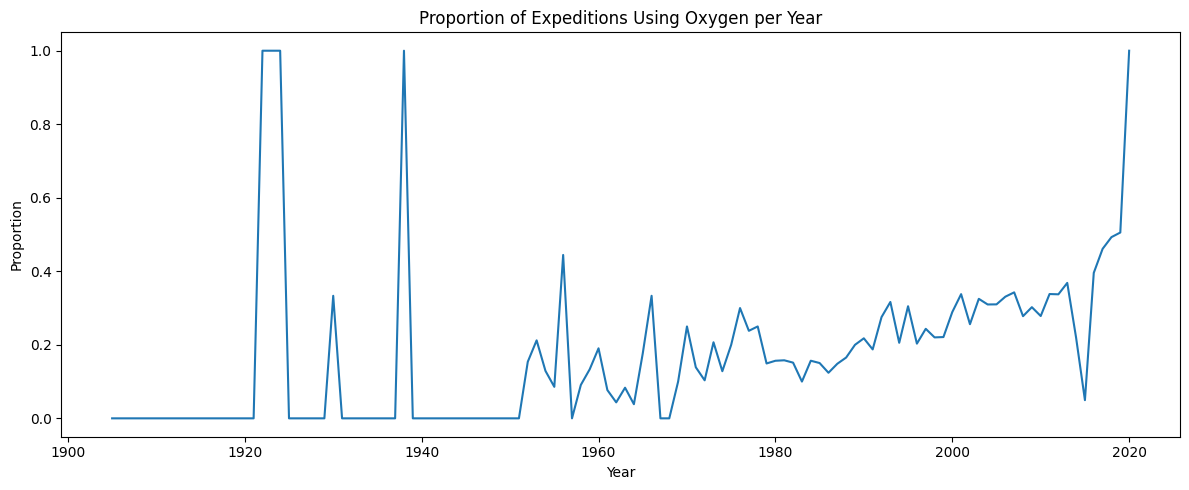

In [29]:
oxygen_use_per_year = exped.groupby('year')['is_o2_used'].mean()

plt.figure(figsize=(12, 5))
oxygen_use_per_year.plot()
plt.title('Proportion of Expeditions Using Oxygen per Year')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()

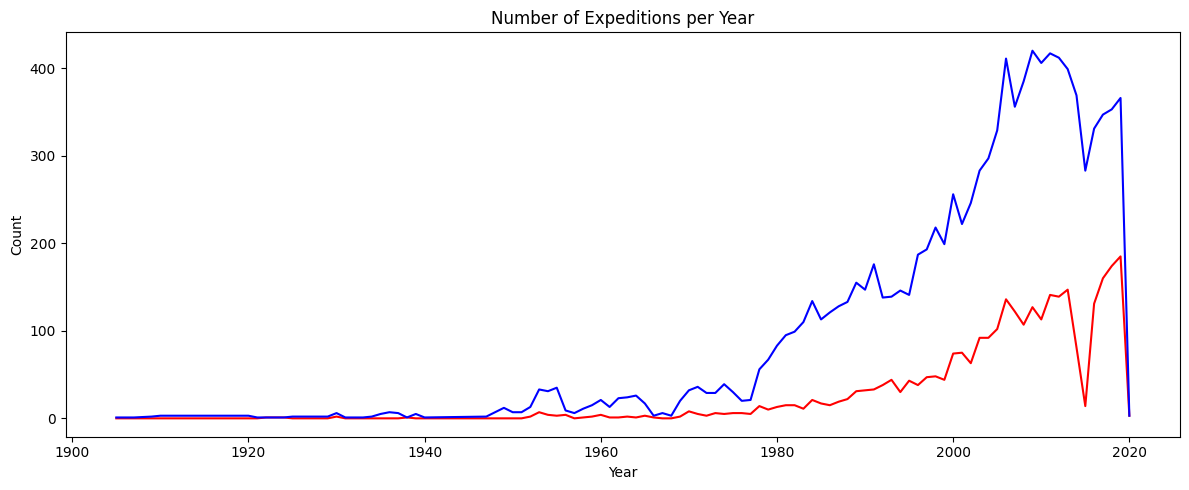

In [39]:
oxygen_use_per_year = exped.groupby('year')['is_o2_used'].sum().sort_index()

plt.figure(figsize=(12, 5))
oxygen_use_per_year.plot(color='red')
exped_per_year.plot(color='blue')
plt.title('Number of Expeditions per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Oxygen use over time

### Success vs fatality rate, rolling window